Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
#from plotly.offline import init_notebook_mode, iplot
#import plotly.graph_objs as go
import glob

#init_notebook_mode(connected=True)

sns.set()
sns.set_style("white")

%matplotlib inline

Function definitions

In [2]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def remove_nan_transpose(varlst):
    Varlst = np.array(varlst)
    res = []
    for i in range(Varlst.shape[1]):
        lst = Varlst[:,i]
        
        #Remove nan
        lst = lst[~np.isnan(lst)]
        
        res.append(lst)
        
    return res

def start_simulation_parallel(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        y += (-y + u - v + np.random.randn(ntrials) * sigma) / 100 * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)    
        
    return u_lst, v_lst, y_lst, I_lst, sig_lst

# Functions for using in a for loop
def get_times_lst_from_y(ylst, threshold):
    ndiscard = 10
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def simulate_trial(ntrials=1000, duration=600, nstages=10, sigma=0, K=3.0, initI=0.7):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    PARAMS_DICT['sigma'] = sigma
    PARAMS_DICT['K'] = K
    
    nbin = int(duration / PARAMS_DICT['dt'])

    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * 0.7, 
                  np.ones(ntrials) * 0.2,
                  np.ones(ntrials) * 0.5,
                  0.0]

    if nstages > 1:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
    else:
        ulst, vlst, ylst, Ilst, siglst = start_simulation_parallel(state_init, PARAMS_DICT, 100)

    # For subsequent runs, flip the state every 100 trials
    for k in range((nstages - 2) * 2):
        #acoefs = 1 - acoefs
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        if state_init[4] == 0.0:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, nbin)
        else:
            ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2

    if nstages > 1:
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 1)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        siglst += siglst2
        
        state_init = [Ilst[-1], ulst[-1], vlst[-1], ylst[-1], (state_init[4] + 1.0)%2]
        # For the last run, produce the behavior when the threshold is reached
        ulst2, vlst2, ylst2, Ilst2, siglst2 = start_simulation_parallel(state_init, PARAMS_DICT, 200)

        ulst += ulst2
        vlst += vlst2
        ylst += ylst2
        Ilst += Ilst2
        
        siglst2[nbin] = 1
        siglst += siglst2
    else:
        siglst[nbin] = 1
        ylst2 = ylst

    return ulst, vlst, ylst, Ilst, siglst, ylst2

def plot_simulation_parallel(ulst, vlst, ylst, Ilst, siglst, params_dict):
    '''Plot the simulations'''
    dt = params_dict['dt']
    nsteps = len(ulst)
    tlst = np.arange(nsteps).astype('int')
    sig_lst = np.floor(tlst / 100) % 2
    sig_lst = sig_lst.astype('int')
    
    ulst_arr = np.array(ulst)
    vlst_arr = np.array(vlst)
    ylst_arr = np.array(ylst)
    Ilst_arr = np.array(Ilst)
    
    wherelst = np.array(siglst) == 1.0
    wherelst_shifted = np.concatenate((wherelst[1:], [False]))
    wherelst += wherelst_shifted
    
    #wherelst2 = np.array(siglst) == 2.0

    fig, ax = plt.subplots(4, 1, figsize=(10, 10))
    ax[0].plot(np.arange(nsteps) * dt, ulst_arr, 'b', alpha=0.2)
    ax[0].set_ylabel('u')
    ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst, alpha=0.5)
    #ax[0].fill_between(np.arange(nsteps) * dt, np.min(np.array(ulst)), np.max(np.array(ulst)), where=wherelst2, alpha=0.2)

    ax[1].plot(np.arange(nsteps) * dt, vlst_arr, 'b', alpha=0.2)
    ax[1].set_ylabel('v')
    ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst, alpha=0.5)
    #ax[1].fill_between(np.arange(nsteps) * dt, np.min(np.array(vlst)), np.max(np.array(vlst)), where=wherelst2, alpha=0.2)

    ax[2].plot(np.arange(nsteps) * dt, ylst_arr, 'b', alpha=0.2)
    ax[2].set_ylabel('y')
    ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst, alpha=0.5)
    #ax[2].fill_between(np.arange(nsteps) * dt, np.min(np.array(ylst)), np.max(np.array(ylst)), where=wherelst2, alpha=0.2)
    ax[2].hlines(0.7, 0, nsteps * dt, linestyle='dotted')

    ax[3].plot(np.arange(nsteps) * dt, Ilst_arr, 'b', alpha=0.2)
    ax[3].set_ylabel('I')
    ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst, alpha=0.5)
    #ax[3].fill_between(np.arange(nsteps) * dt, np.min(np.array(Ilst)), np.max(np.array(Ilst)), where=wherelst2, alpha=0.2)
    ax[3].set_xlabel('Time (ms)');
    
def get_times_lst_from_y(ylst, threshold):
    ndiscard = 10
    # Discard first 10 samples
    ylst = ylst[ndiscard:]
    times_lst = []
    
    # Find time to act
    for k in range(ntrials):
        # Check if the bound is reached (sometimes it's not!)
        if np.max(ylst[:,k]) > threshold:
            times_lst.append(np.nonzero(ylst[:, k] > threshold)[0][0])
        else:
            times_lst.append(np.inf)
            #print('Bound not reached')
    
    return np.array(times_lst) + ndiscard

def start_simulation_to_thresh(state_init, params, niter):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    K = params['K']
    sigma = params['sigma']
    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    u = u.copy()
    v = v.copy()
    y = y.copy()
        
    sig_lst = []
    u_lst = []
    v_lst = []
    y_lst = []
    I_lst = []
    
    for i in range(niter):                
        # I update here:
        I += (sig * K * (y - y0)) / 100 * dt
        

        # u-v and y update
        if sig == 0:
            u += (-u + thresh_exp(Wut * I - Wuv * v + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 0 + np.random.randn(ntrials) * sigma)) / tau * dt
        else:
            u += (-u + thresh_exp(Wut * I - Wuv * v - 50 + np.random.randn(ntrials) * sigma)) / tau * dt
            v += (-v + thresh_exp(Wvt * I - Wvu * u + 50 + np.random.randn(ntrials) * sigma)) / tau * dt

        y += (-y + u - v + np.random.randn(ntrials) * sigma) / 100 * dt

        v_lst.append(v.copy())
        u_lst.append(u.copy())
        y_lst.append(y.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig)
        
        y[y > y0] = np.nan
        
        #print(np.sum(~np.isnan(y)))
        # Terminate once threshold is reached
        if np.sum(~np.isnan(y)) == 0:
            #print(np.sum(~np.isnan(y)))
            #print('Breaking at ', i, '...')
            break
            
    
    return u_lst, v_lst, y_lst, I_lst, sig_lst

Parameters

In [3]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'K': 8.0,
              'sigma': 0.05,
              'alpha': 1}

In [4]:
PARAMS_DICT = {'Wut': 6,
              'Wuv': 6,
              'Wvt': 6,
              'Wvu': 6,
              'dt': 10,
              'tau': 100,
              'ext': 0,
              'y0': 0.7,
              'IF': 100,
              'uinit': 0.7,
              'vinit': 0.2,
              'yinit': 0.5,
              'first_duration': 750}

Now lets try doing some phase shifts

In [5]:
def gauss_derivative(x,sig,amp):
    y = -amp / np.sqrt(2*np.pi*np.power(sig,2)) * x / np.power(sig,2) * np.exp( -np.power(x,2) / (2*np.power(sig,2)) )
    
    return y
    
def dual_process_model_generalized(state_init, params, niter, durations, sigma, K, alpha):
    '''
    Inputs:
    state_init: an array which includes:
        * I: initial current
        * u: initial state of u
        * v: initial state of v
        * y: initial state of y (readout neuron)
        * sig: state indicator (0 or 1)
        
    params: a dictionary of relevant parameters
    niter: number of iterations
    
    Outputs: each list contains niter elements
    u_lst: list of u activities 
    v_lst: list of v activities
    y_lst: list of y activities
    I_lst: list of I activities
    sig_lst: list of sig in this simulation
        
    '''
    
    # Unpack parameters of the simulation
    Wut = params['Wut']
    Wuv = params['Wut']
    Wvt = params['Wut']
    Wvu = params['Wut']
    dt = params['dt']
    tau = params['tau']
    ext = params['ext']
    y0 = params['y0'] #The target (threshold) value of y
    IF = params['IF']
    
    first_duration = PARAMS_DICT['first_duration']
    nbinfirst = int(first_duration / dt)

    
    # Unpack variables
    I, u, v, y, sig = state_init
    
    ntrials = len(I)
    
    I = I.copy()
    uS = u.copy()
    vS = v.copy()
    yS = y.copy()
    
    IP = I.copy()
    uP = u.copy()
    vP = v.copy()
    yP = y.copy()
        
    sig_lst = []
    u_sim = []
    v_sim = []
    y_sim = []
    I_lst = []
    
    u_p = []
    v_p = []
    y_p = []
    I_p = []
    production_lst = []
    
    durs = np.cumsum(np.divide(durations,dt))
    durs = durs.astype(int)
    
    # Make the first duration constant
    durs += (nbinfirst - durs[0])

    #print(durs)
    
    for i in range(niter): 
        # First flash, no I update
        if i == durs[0]:
            #print(i, 'first flash')
            sig = 1.0
        elif any(i == durs):
            sig = 1.0
            I += (sig * K * (yS - y0)) / tau * dt
            #print(i, 'flash')
        else:
            sig = 0.0
            I += (sig * K * (yS - y0)) / tau * dt
        
        

        # u-v and y update
        uS += (-uS + thresh_exp(Wut * I - Wuv * vS - sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        vS += (-vS + thresh_exp(Wvt * I - Wvu * uS + sig * IF + np.random.randn(ntrials) * sigma)) / tau * dt
        yS += (-yS + uS - vS + np.random.randn(ntrials) * sigma) / 100 * dt

        v_sim.append(vS.copy())
        u_sim.append(uS.copy())
        y_sim.append(yS.copy())
        I_lst.append(I.copy())
        sig_lst.append(sig) 
        
        
        # u-v and y update
        sigP = (yP >= y0).astype('float')
        uP += (-uP + thresh_exp(Wut * IP - Wuv * vP - IF * sigP + np.random.randn(ntrials) * sigma)) / tau * dt
        vP += (-vP + thresh_exp(Wvt * IP - Wvu * uP + IF * sigP + np.random.randn(ntrials) * sigma)) / tau * dt
        yP += (-yP + uP - vP + np.random.randn(ntrials) * sigma) / tau * dt
        
        yPcurr = yP.copy()
        yScurr = yS.copy()
        
        IP = I.copy() + alpha*(yP.copy() - yS.copy())

        v_p.append(vP.copy())
        u_p.append(uP.copy())
        y_p.append(yP.copy())
        I_p.append(IP.copy())
        production_lst.append(sigP)
        
    return u_sim, v_sim, y_sim, I_lst, sig_lst, u_p, v_p, y_p, I_p, production_lst

In [6]:
def simulate_synchronization2(sigma, K, initI, alpha, ntrials=1, durations=[600, 600, 600, 600, 1000, 600, 600]):
    # Initial run
    #ntrials = 1000
    #duration = 600 #ms
    #nstages = 10
    
    nbin = int(sum(np.divide(durations,PARAMS_DICT['dt'])))
    
    #print(nbin)
    state_init = [np.ones(ntrials) * initI, 
                  np.ones(ntrials) * PARAMS_DICT['uinit'], 
                  np.ones(ntrials) * PARAMS_DICT['vinit'],
                  np.ones(ntrials) * PARAMS_DICT['yinit'],
                  0.0]

    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = dual_process_model_generalized(state_init, 
                                                                        PARAMS_DICT, nbin, durations, sigma, K, alpha)


    return usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, np.array(production_lst) 

def asynchronies(sig_lst,production_lst,dt):
    press_times = np.multiply(np.nonzero(production_lst)[0],dt)
    flash_times = np.multiply(np.nonzero(sig_lst)[0],dt)
    if np.size(flash_times) >= np.size(press_times):
        asynch = press_times - flash_times[:np.size(press_times)]
    else:
        asynch = press_times[:np.size(flash_times)] - flash_times
    return asynch, press_times, flash_times
        
def asynchronies_multi(sig_lst,production_lst,dt):
    Production_lst = np.array(production_lst)
    asynch_lst, press_times_lst, flash_times_lst = [], [], []
    
    # Compute asynchronies for each column of the matrix
    for i in range(Production_lst.shape[1]):
        asynch_single, press_times_single, flash_times_single = asynchronies(sig_lst, 
                            Production_lst[:,i], dt)
        asynch_lst.append(asynch_single)
        press_times_lst.append(press_times_single)
        flash_times_lst.append(flash_times_single)
        
    return asynch_lst, press_times_lst, flash_times_lst

def isi_ipi(sig_lst,production_lst,dt):
    press_times = np.multiply(np.nonzero(production_lst),dt)
    flash_times = np.multiply(np.nonzero(sig_lst),dt)
    
    isi = np.diff(flash_times)
    ipi = np.diff(press_times)
    
    return isi, ipi, press_times, flash_times

Event onset shift

## Synchronization-continuation simulation

Here, we try to simulate the synchronization-continuation experiment, and compare the simulation to data provided by Evan.

[[ 0  0  0  0  0  0  0  0  0 57  0  0  0  0  0  0  0  0  0 64  0  0  0  0
   0  0  0  0  0 69  0  0  0  0  0  0  0  0  0 71  0  0  0  0  0  0  0  0
   0 49  0  0  0  0  0  0  0  0  0 48  0  0  0  0  0  0  0  0  0 48  0  0
   0  0  0  0  0  0  0 48  0  0  0  0  0  0  0  0  0 48  0  0  0  0  0  0
   0  0  0 48  0  0  0  0  0  0  0  0  0 48  0  0  0  0  0  0  0  0  0 48
   0  0  0  0  0  0  0  0  0 48  0  0  0  0  0  0  0  0  0 48  0  0  0  0
   0  0  0  0  0 48  0  0  0  0  0  0  0  0  0 48  0  0  0  0  0  0  0  0
   0 48  0  0  0  0  0  0  0  0  0]
 [ 1  1  1  1  1  1  1  1  1 -9  1  1  1  1  1  1  1  1  1 -9  1  1  1  1
   1  1  1  1  1 -9  1  1  1  1  1  1  1  1  1 -9  1  1  1  1  1  1  1  1
   1 -9  1  1  1  1  1  1  1  1  1 -9  1  1  1  1  1  1  1  1  1 -9  1  1
   1  1  1  1  1  1  1 -9  1  1  1  1  1  1  1  1  1 -9  1  1  1  1  1  1
   1  1  1 -9  1  1  1  1  1  1  1  1  1 -9  1  1  1  1  1  1  1  1  1 -9
   1  1  1  1  1  1  1  1  1 -9  1  1  1  1  1  1  1  1  1 -9  1  1  1  1
  

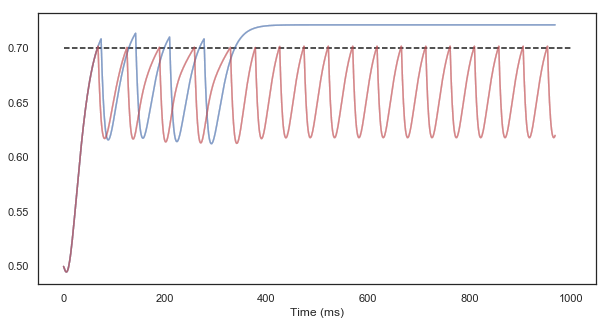

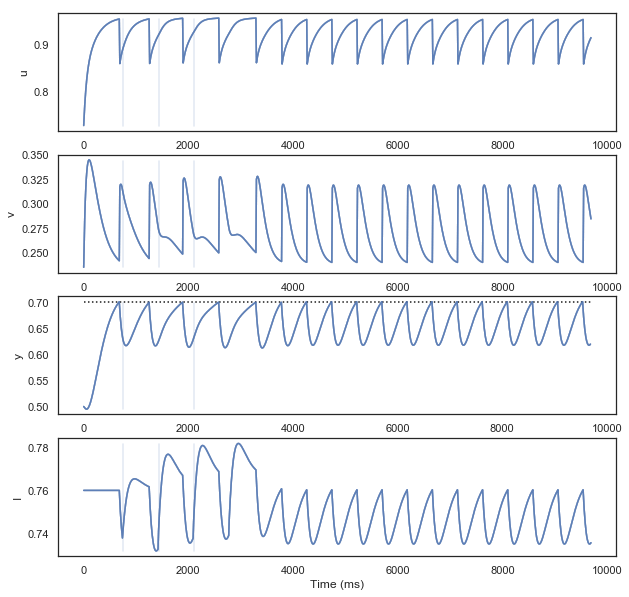

In [7]:
usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=10, 
                                                                               durations=[675.0] * 4 + [7000], 
                                                                               sigma=0.0, K=2, initI=0.76, alpha = 0.3)


plt.figure(figsize=(10, 5))
#a = remove_nan_transpose(siglst)
#for i in range(len(a)):
#    plt.plot(np.arange(len(a[i])) * 10, a[i], 'b', alpha=0.1)
plt.plot(ysim, 'b', alpha=0.1)
plt.plot(y_p, 'r', alpha=0.1)
plt.xlabel('Time (ms)')
#plt.ylabel('y')
plt.hlines(0.7, 0, 1000*10/PARAMS_DICT['dt'], linestyles='--')
print(np.diff(np.nonzero(production_lst)))


plot_simulation_parallel(u_p, v_p, y_p, I_p, siglst, PARAMS_DICT)


Here, we try to simulate just the synchronization phase to find the appropriate parameters ($K, \alpha, \sigma, I_{init}$)

Some comments: 

* If $\alpha = 0$, the network exhibits a simple integration, with the IPI starting from the mean of the distribution and slowly approaching the desired interval with a rate controlled by $K$.

(500, 900)

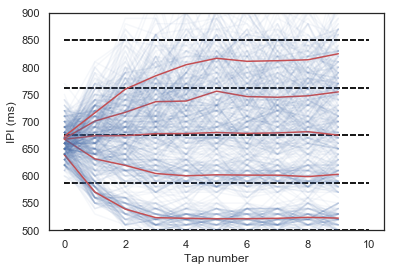

In [8]:
durs = np.linspace(500, 850, 5)

for interval in durs:
    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=100, 
                                                                               durations=[interval] * 5 + [10000], 
                                                                               sigma=0.01, K=3, initI=0.77, alpha = 0.0)
    
    # Find the IPI (inter-production interval)
    ipi_lst = []
    for i in range(production_lst.shape[1]):
        single_production = production_lst[:,i]
        #print(len(np.nonzero(single_production)[0]))
        ipi_lst.append(np.diff(np.nonzero(single_production)[0])[:10])

    plt.plot(np.array(ipi_lst).T * 10, 'b', alpha=0.05)
    meanline = np.mean(np.array(ipi_lst), axis=0)
    plt.plot(meanline * 10, 'r')
    plt.hlines(durs, 0, 10, linestyles='--')
    
plt.xlabel('Tap number')
plt.ylabel('IPI (ms)')
plt.ylim((500, 900))

Now we examine the effect of varying $\alpha$. Remember that $\alpha$ controls the coupling between the simulator and the plant to account for the phase of the two.

``IP = I.copy() + alpha*(yP.copy() - yS.copy())``

The simulation shows that as we increase $\alpha$, the increase in bias in the synchronization phase becomes more pronounced.

Text(0, 0.5, 'IPI (ms)')

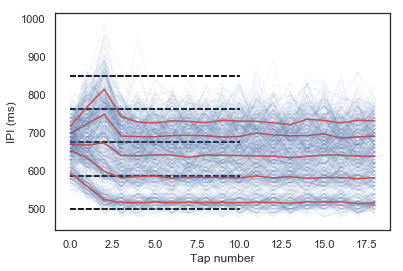

In [9]:
durs = np.linspace(500, 850, 5)
meanITIs = []

for interval in durs:
    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(sigma=0.01, K=2.5, 
                                                                            initI=0.77, alpha = 0.05, ntrials=100, 
                                                                               durations=[interval] * 4 + [20000])
    
    # Find the IPI (inter-production interval)
    ipi_lst = []
    for i in range(production_lst.shape[1]):
        single_production = production_lst[:,i]
        #print(len(np.nonzero(single_production)[0]))
        ipi_lst.append(np.diff(np.nonzero(single_production)[0])[1:20])

    plt.plot(np.array(ipi_lst).T * 10, 'b', alpha=0.05)
    meanline = np.mean(np.array(ipi_lst), axis=0)
    meanITIs.append(meanline)
    plt.plot(meanline * 10, 'r')
    plt.hlines(durs, 0, 10, linestyles='--')
    
plt.xlabel('Tap number')
plt.ylabel('IPI (ms)')
#plt.ylim((500, 900))

Text(0, 0.5, 'Bias')

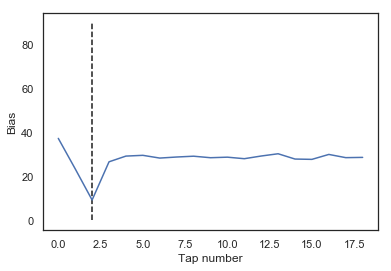

In [10]:
# Plot the bias for all of the conditions
meanITIs = np.array(meanITIs)
bias_individual = meanITIs * 10 - durs[:,np.newaxis]
bias_all_sim = np.sum(bias_individual**2, axis=0)
plt.plot(np.sqrt(bias_all_sim) / len(durs))
plt.vlines(2, 0, 90, linestyles='--')
plt.xlabel('Tap number')
plt.ylabel('Bias')

Now, we compare the result of the simulation to behavioral data.

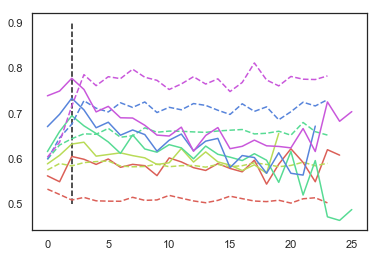

In [11]:
### Simulation ###
durs = np.linspace(500, 850, 5)
meanITIs = []

for interval in durs:
    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=40, 
                                                                               durations=[interval] * 4 + [interval * 30],  
                                                                               sigma=0.02, K=4, initI=0.76, alpha = 0.0)
    
    # Find the IPI (inter-production interval)
    ipi_lst = []
    for i in range(production_lst.shape[1]):
        single_production = production_lst[:,i]
        #print(len(np.nonzero(single_production)[0]))
        ipi_lst.append(np.diff(np.nonzero(single_production)[0])[1:25])

    meanline = np.mean(np.array(ipi_lst), axis=0)
    meanITIs.append(meanline)

meanITIs = np.array(meanITIs)
bias_individual = meanITIs * 10 - durs[:,np.newaxis]
bias_all = np.sum(bias_individual**2, axis=0)

### Plotting ###
palette = sns.color_palette('hls', 5)

# Load the processed data
filename = 'AL1_20180718_syncon_ITIs.mat'
data = scipy.io.loadmat(filename)
durs = data['durs'].flatten()
splits = data['allDur_splits']

# Plot the mean IPI
IPI_mean = data['allDur_mean']
for i in range(5):
    plt.plot(IPI_mean[0,i].T, color=palette[i])
    plt.plot(meanITIs[i,:] / 100, '--', color=palette[i]);
    
plt.vlines(2, 0.5, 0.90, linestyles='--')


In [12]:
trials = splits[0,0]
N = trials.shape[0]

# Get number of taps for each trial
ntaps = np.sum(~np.isnan(trials), axis=1)
maxtaps = max(ntaps)

In [13]:
### Simulation, with the correct number of trials ###
#durs = np.linspace(500, 850, 5)
meanITIs = []

for interval in [550]:
    usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=N, 
                                                                               durations=[interval] * 4 + [interval * (maxtaps + 3)],  
                                                                               sigma=0.02, K=4, initI=0.76, alpha = 0.0)
    
    # Find the IPI (inter-production interval)
    ipi_lst = []
    for i in range(production_lst.shape[1]):
        single_production = production_lst[:,i]
        #print(len(np.nonzero(single_production)[0]))
        tap_intervals = np.diff(np.nonzero(single_production)[0])[1:maxtaps].astype('float')
        tap_intervals[ntaps[i]:] = np.nan
        ipi_lst.append(tap_intervals)

    meanline = np.nanmean(np.array(ipi_lst), axis=0)
    meanITIs.append(meanline)

IPIs = np.array(ipi_lst)
meanITIs = np.array(meanITIs)
bias_individual = meanITIs * 10 - durs[:,np.newaxis]
bias_all = np.sum(bias_individual**2, axis=0)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


(0.5, 0.9)

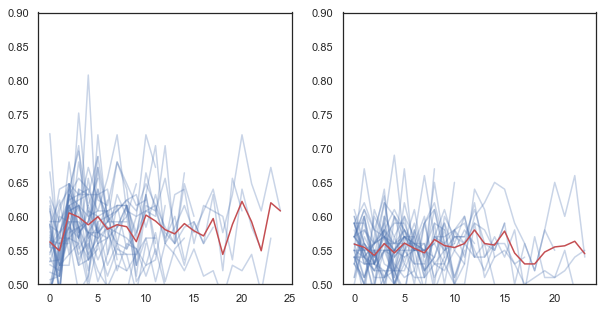

In [14]:
plt.figure(figsize=(10,5))

plt.subplot('121')
plt.plot(trials.T, 'b', alpha=0.3);
plt.plot(np.nanmean(trials, axis=0), 'r')
plt.ylim((0.5, 0.9))


plt.subplot('122')
plt.plot(IPIs.T / 100, 'b', alpha=0.3);
plt.plot(meanITIs[0,:] / 100, 'r');
plt.ylim((0.5, 0.9))

In [131]:
def find_bias_all(IPI_mean, durs, tmax):
    '''IPI_mean: an array of mean intervals
    Returns the average bias profile across the different trial durations'''
    Bias = np.zeros((tmax, 5))

    for i in range(len(IPI_mean)):
        IPI_single = IPI_mean[i].flatten()[:tmax]
        bias_single = IPI_single - durs[i]
        Bias[:,i] = bias_single

    return np.sqrt(np.nanmean(Bias**2, axis=1)) * 1000

def find_bias_arr(filename, tmax):
    '''filename: SynCon_ITIs file name
    tmax: max number of taps to consider
    
    Returns: the bias array, tmax x number of intervals in prior'''
    data = scipy.io.loadmat(filename)
    durs = data['durs'].flatten()
    splits = data['allDur_splits']
    IPI_mean = data['allDur_mean'][0]
    
    Bias = np.zeros((tmax, 5))

    for i in range(len(IPI_mean)):
        IPI_single = IPI_mean[i].flatten()[:tmax]
        bias_single = IPI_single - durs[i]
        Bias[:,i] = bias_single
    
    return Bias


def find_std_arr(filename, tmax):
    '''filename: SynCon_ITIs file name
    tmax: max number of taps to consider
    
    Returns: the bias array, tmax x number of intervals in prior'''
    data = scipy.io.loadmat(filename)
    durs = data['durs'].flatten()
    splits = data['allDur_splits']
    IPI_std = data['allDur_std'][0]
    
    STD = np.zeros((tmax, 5))

    for i in range(len(IPI_std)):
        std_single = IPI_std[i].flatten()[:tmax]
        STD[:,i] = std_single
    
    return STD
    

In [110]:
data['allDur_std']

array([[array([[0.05301317, 0.0401153 , 0.03532442, 0.05392768, 0.05772892,
        0.05047907, 0.0399213 , 0.05354049, 0.0437433 , 0.04376361,
        0.05407562, 0.05271134, 0.06054056, 0.02763942, 0.05499176,
        0.01937338, 0.04217956, 0.04819994, 0.05426105, 0.06547344,
        0.0827209 , 0.05246187, 0.06003117, 0.073549  , 0.        ,
               nan,        nan,        nan]]),
        array([[0.06993837, 0.06811092, 0.04136679, 0.0635162 , 0.05115959,
        0.05475629, 0.06753064, 0.07192969, 0.05361535, 0.06758403,
        0.03990452, 0.05714154, 0.05065382, 0.07572867, 0.07116811,
        0.06576965, 0.06105909, 0.0776959 , 0.0415672 , 0.        ,
               nan,        nan,        nan,        nan,        nan,
               nan,        nan,        nan]]),
        array([[0.07690698, 0.07854111, 0.05131226, 0.07140125, 0.07786154,
        0.06985139, 0.04919873, 0.08548054, 0.05964208, 0.04349561,
        0.08861301, 0.05184949, 0.06658462, 0.08499982, 0.0590722 

In [16]:
dirlst = glob.glob('C:\\Users\\Sur lab\\Dropbox (MIT)\\Jazayeri\\SyncContData\\*_2_*ITIs.mat')

In [17]:
dirlst

['C:\\Users\\Sur lab\\Dropbox (MIT)\\Jazayeri\\SyncContData\\AL_2_20170719_SynCon_ITIs.mat',
 'C:\\Users\\Sur lab\\Dropbox (MIT)\\Jazayeri\\SyncContData\\BG_2_20170719_SynCon_ITIs.mat',
 'C:\\Users\\Sur lab\\Dropbox (MIT)\\Jazayeri\\SyncContData\\CA_2_20170719_SynCon_ITIs.mat',
 'C:\\Users\\Sur lab\\Dropbox (MIT)\\Jazayeri\\SyncContData\\ER_2_20170718_SynCon_ITIs.mat',
 'C:\\Users\\Sur lab\\Dropbox (MIT)\\Jazayeri\\SyncContData\\FK_2_20170721_SynCon_ITIs.mat',
 'C:\\Users\\Sur lab\\Dropbox (MIT)\\Jazayeri\\SyncContData\\KL_2_20170721_SynCon_ITIs.mat',
 'C:\\Users\\Sur lab\\Dropbox (MIT)\\Jazayeri\\SyncContData\\MW_2_20170720_SynCon_ITIs.mat',
 'C:\\Users\\Sur lab\\Dropbox (MIT)\\Jazayeri\\SyncContData\\RC_2_20170721_SynCon_ITIs.mat']

In [136]:
def simulate_sync_cont_bias(ntrials, sigma, K, initI, alpha):
    '''Simulate synchronization continuation and return the array of bias'''
    durs = np.linspace(550, 817, 5)
    meanITIs = []
    stdITIs = []

    for interval in durs:
        usim, vsim, ysim, Ilst, siglst, u_p, v_p, y_p, I_p, production_lst = simulate_synchronization2(ntrials=ntrials, 
                                                                                   durations=[interval] * 4 + [20000],  
                                                                                   sigma=sigma, K=K, initI=initI, alpha=alpha)

        # Find the IPI (inter-production interval)
        ipi_lst = []
        for i in range(production_lst.shape[1]):
            single_production = production_lst[:,i]
            #print(len(np.nonzero(single_production)[0]))
            ipi_lst.append(np.diff(np.nonzero(single_production)[0])[1:21])
        if np.array(ipi_lst).ndim != 2:
            return [np.array([]), np.array([])]
        meanline = np.mean(np.array(ipi_lst), axis=0)
        stdline = np.std(np.array(ipi_lst), axis=0)
        meanITIs.append(meanline)
        stdITIs.append(stdline)
        
    meanITIs = np.array(meanITIs)
    #print(meanITIs)
    stdITIs = np.array(stdITIs)
    #print(stdITIs)
    
    bias_individual = meanITIs * 10 - durs[:,np.newaxis]
    bias_all_sim = np.mean(bias_individual**2, axis=0)
    std_all_sim = np.mean(stdITIs**2, axis=0)
    
    return np.sqrt(bias_all_sim), np.sqrt(std_all_sim), meanITIs, stdITIs



C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\AL_2_20170719_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\ER_2_20170718_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\FK_2_20170721_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\KL_2_20170721_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\MW_2_20170720_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\RC_2_20170721_SynCon_ITIs.mat


Text(0, 0.5, 'Bias (ms)')

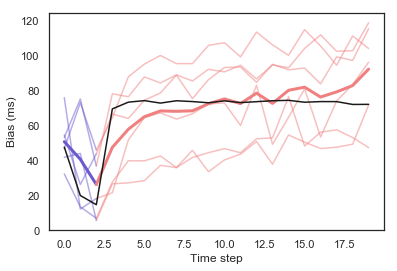

In [146]:
# Load the processed data
plotlst = [0,3,4,5,6,7]
tmax = 20
bias_all_lst = np.zeros((len(plotlst), tmax))
color1 = 'slateblue'
color2 = 'lightcoral'

for id, i in enumerate(plotlst):
    filename = dirlst[i]
    print(filename)
    bias_arr = find_bias_arr(filename, tmax)
    bias = np.sqrt(np.nanmean(bias_arr**2, axis=1)) * 1000
    
    bias_all_lst[id,:] = bias
    plt.plot(bias[:3], color1, alpha=0.5)
    plt.plot(range(2,20), bias[2:], color2, alpha=0.5)
    
#bias_sim_mean, bias_sim_std = simulate_sync_cont_bias(ntrials=21, sigma=0.01, K=3.5, initI=0.755, alpha=0.25)
#bias_sim_mean, bias_sim_std = simulate_sync_cont_bias(ntrials=1000, sigma=0.01, K=1.13, initI=0.763, alpha=0.2)
bias_sim_mean, bias_sim_std, _, _ = simulate_sync_cont_bias(ntrials=1000, sigma=0.02, K=4.273717912747279, 
                                                      initI=0.7713620642763795, alpha=0.09251639067454985)

#1.1666867783815724 0.7658983506973202 0.1900332359160799

## Plot Figure 8e
plt.plot(np.nanmean(bias_all_lst,axis=0)[:3], color1, linewidth=3)
plt.plot(range(2,20), np.nanmean(bias_all_lst,axis=0)[2:], color2, linewidth=3)
plt.plot(bias_sim_mean, 'k')
plt.xlabel('Time step')
plt.ylabel('Bias (ms)')

In [147]:
scipy.io.savemat('PlotTools/sync_cont_figure_021619.mat', {'bias_all_lst': bias_all_lst,
                                                          'bias_means': np.nanmean(bias_all_lst,axis=0),
                                                          'bias_sim': bias_sim_mean,
                                                          'Ival': Isummary,
                                                          'Kval': Ksummary,
                                                          'alphaval': alphasummary})

## Parameter optimization

In [143]:
def do_sync_cont_fitting(target, nsamples, niter, ntrials, sigma, Krange, Irange, alpha_range):
    Klst = np.random.uniform(low=Krange[0], high=Krange[1], size=nsamples)
    Ilst = np.random.uniform(low=Irange[0], high=Irange[1], size=nsamples)
    alphalst = np.random.uniform(low=alpha_range[0], high=alpha_range[1], size=nsamples)
    mselst = []
    for i in range(nsamples):
        K = Klst[i]
        initI = Ilst[i]
        alpha = alphalst[i]
        bias_sim_mean, _, _, _ = simulate_sync_cont_bias(ntrials=ntrials, sigma=sigma, K=K, initI=initI, alpha=alpha)
        if len(bias_sim_mean) == 0:
            print('Bad trial')
            continue
        mse = np.sum((bias_sim_mean - target)**2)
        print('    Iter %d: K = %.4f, I = %.4f, alpha = %.4f, mse = %.4f' % (i, K, initI, alpha, mse))
        mselst.append(mse)
    id = np.argmin(mselst)
    return Ilst[id], Klst[id], alphalst[id]

In [144]:
niter = 1
nsamples = 200

np.random.seed(123)

target = np.nanmean(bias_all_lst, axis=0)
Isummary = []
Ksummary = []
alphasummary = []

for k in range(niter):
    print('## Iteration number ', k)
    Ival, Kval, alphaval = do_sync_cont_fitting(target, nsamples, niter, ntrials=21, sigma=0.01, 
                                               Krange=[0.01, 5], Irange=[0.76, 0.78], alpha_range=[0.01, 0.1])
    Isummary.append(Ival)
    Ksummary.append(Kval)
    alphasummary.append(alphaval)

## Iteration number  0
    Iter 0: K = 3.4854, I = 0.7709, alpha = 0.0511, mse = 14851.8635
    Iter 1: K = 1.4378, I = 0.7613, alpha = 0.0352, mse = 55027.3493
    Iter 2: K = 1.1420, I = 0.7731, alpha = 0.0940, mse = 5537.5793
    Iter 3: K = 2.7611, I = 0.7799, alpha = 0.0383, mse = 50079.0076
    Iter 4: K = 3.6002, I = 0.7754, alpha = 0.0919, mse = 4344.0604
    Iter 5: K = 2.1213, I = 0.7715, alpha = 0.0139, mse = 21867.6697
    Iter 6: K = 4.9040, I = 0.7621, alpha = 0.0736, mse = 4336.2315
    Iter 7: K = 3.4273, I = 0.7740, alpha = 0.0536, mse = 19027.8601
    Iter 8: K = 2.4099, I = 0.7732, alpha = 0.0500, mse = 16639.3715
    Iter 9: K = 1.9667, I = 0.7610, alpha = 0.0133, mse = 24215.5205
    Iter 10: K = 1.7225, I = 0.7758, alpha = 0.0137, mse = 16091.1998
    Iter 11: K = 3.6480, I = 0.7704, alpha = 0.0399, mse = 20094.5259
    Iter 12: K = 2.1985, I = 0.7685, alpha = 0.0952, mse = 8088.9078
    Iter 13: K = 0.3078, I = 0.7758, alpha = 0.0656, mse = 26961.2564
    Iter 14

    Iter 118: K = 0.0234, I = 0.7711, alpha = 0.0458, mse = 20991.9180
    Iter 119: K = 4.9418, I = 0.7700, alpha = 0.0530, mse = 18880.8088
    Iter 120: K = 4.5277, I = 0.7601, alpha = 0.0655, mse = 5606.8569
    Iter 121: K = 1.0461, I = 0.7696, alpha = 0.0464, mse = 5307.5525
    Iter 122: K = 1.4695, I = 0.7785, alpha = 0.0993, mse = 30336.6295
    Iter 123: K = 2.6049, I = 0.7640, alpha = 0.0189, mse = 9191.0940
    Iter 124: K = 4.5105, I = 0.7610, alpha = 0.0299, mse = 22679.9306
    Iter 125: K = 4.9183, I = 0.7681, alpha = 0.0390, mse = 28260.5887
    Iter 126: K = 1.2951, I = 0.7674, alpha = 0.0233, mse = 7329.7911
    Iter 127: K = 2.8262, I = 0.7771, alpha = 0.0356, mse = 44133.2102
    Iter 128: K = 4.0368, I = 0.7605, alpha = 0.0801, mse = 4660.0062
    Iter 129: K = 1.9779, I = 0.7784, alpha = 0.0571, mse = 34946.5226
    Iter 130: K = 3.6581, I = 0.7736, alpha = 0.0131, mse = 51770.6609
    Iter 131: K = 0.8137, I = 0.7781, alpha = 0.0984, mse = 23620.5852
    Iter 13

## Fit  to individual subjects

In [148]:
nsamples = 100
Isummary = []
Ksummary = []
alphasummary = []

for id in range(bias_all_lst.shape[0]):
    print('Doing subject # %d of %d' % (id + 1, bias_all_lst.shape[0]))
    target = bias_all_lst[id, :]
    Ival, Kval, alphaval = do_sync_cont_fitting(target, nsamples, niter, ntrials=21, sigma=0.01, 
                                               Krange=[0.01, 5], Irange=[0.76, 0.78], alpha_range=[0.01, 0.1])
    Isummary.append(Ival)
    Ksummary.append(Kval)
    alphasummary.append(alphaval)
    

Doing subject # 1 of 6
    Iter 0: K = 3.0251, I = 0.7621, alpha = 0.0677, mse = 8573.2903
    Iter 1: K = 2.6365, I = 0.7649, alpha = 0.0454, mse = 16770.1902
    Iter 2: K = 2.9975, I = 0.7623, alpha = 0.0569, mse = 9213.3457
    Iter 3: K = 1.8094, I = 0.7623, alpha = 0.0647, mse = 13393.6759
    Iter 4: K = 2.9489, I = 0.7712, alpha = 0.0157, mse = 82045.7791
    Iter 5: K = 0.9694, I = 0.7760, alpha = 0.0801, mse = 40502.3387
    Iter 6: K = 3.6616, I = 0.7719, alpha = 0.0826, mse = 31838.4685
    Iter 7: K = 2.7738, I = 0.7766, alpha = 0.0373, mse = 109006.3485
    Iter 8: K = 0.7807, I = 0.7698, alpha = 0.0275, mse = 11591.2627
    Iter 9: K = 0.8554, I = 0.7704, alpha = 0.0623, mse = 7247.7703
    Iter 10: K = 0.0231, I = 0.7666, alpha = 0.0893, mse = 42653.8528
    Iter 11: K = 0.0751, I = 0.7684, alpha = 0.0182, mse = 7997.5105
    Iter 12: K = 2.6630, I = 0.7662, alpha = 0.0219, mse = 43293.1585
    Iter 13: K = 3.4132, I = 0.7755, alpha = 0.0441, mse = 86123.8486
    Iter 1

    Iter 17: K = 0.4575, I = 0.7757, alpha = 0.0348, mse = 29203.6448
    Iter 18: K = 4.1913, I = 0.7725, alpha = 0.0167, mse = 49815.7218
    Iter 19: K = 3.6372, I = 0.7707, alpha = 0.0468, mse = 14055.6011
    Iter 20: K = 1.8372, I = 0.7774, alpha = 0.0333, mse = 20686.0382
    Iter 21: K = 1.7311, I = 0.7711, alpha = 0.0209, mse = 9808.7321
    Iter 22: K = 4.9399, I = 0.7655, alpha = 0.0168, mse = 36062.4396
    Iter 23: K = 3.9160, I = 0.7687, alpha = 0.0975, mse = 6404.0747
    Iter 24: K = 4.0761, I = 0.7702, alpha = 0.0494, mse = 16405.7282
    Iter 25: K = 4.1168, I = 0.7749, alpha = 0.0607, mse = 14247.2537
    Iter 26: K = 4.7604, I = 0.7643, alpha = 0.0874, mse = 5544.8308
    Iter 27: K = 1.5432, I = 0.7601, alpha = 0.0673, mse = 109949.9542
    Iter 28: K = 4.8083, I = 0.7784, alpha = 0.0706, mse = 12585.9021
    Iter 29: K = 3.9105, I = 0.7617, alpha = 0.0478, mse = 8766.9485
    Iter 30: K = 3.6468, I = 0.7628, alpha = 0.0820, mse = 8469.5539
    Iter 31: K = 0.8038,

    Iter 35: K = 1.7804, I = 0.7670, alpha = 0.0196, mse = 20338.8865
    Iter 36: K = 1.6133, I = 0.7625, alpha = 0.0362, mse = 77342.4565
    Iter 37: K = 3.6107, I = 0.7656, alpha = 0.0201, mse = 4815.3592
    Iter 38: K = 2.3804, I = 0.7610, alpha = 0.0542, mse = 69780.0456
    Iter 39: K = 2.5328, I = 0.7782, alpha = 0.0444, mse = 13885.0583
    Iter 40: K = 0.2583, I = 0.7780, alpha = 0.0682, mse = 125313.2940
    Iter 41: K = 0.1078, I = 0.7752, alpha = 0.0600, mse = 69868.3435
    Iter 42: K = 1.7321, I = 0.7745, alpha = 0.0708, mse = 7275.4217
    Iter 43: K = 3.3602, I = 0.7694, alpha = 0.0377, mse = 4118.2556
    Iter 44: K = 3.5604, I = 0.7641, alpha = 0.0214, mse = 5942.7141
    Iter 45: K = 3.8729, I = 0.7740, alpha = 0.0267, mse = 15948.9062
    Iter 46: K = 2.0453, I = 0.7601, alpha = 0.0736, mse = 122975.8128
    Iter 47: K = 3.7029, I = 0.7672, alpha = 0.0465, mse = 3161.1836
    Iter 48: K = 3.4914, I = 0.7636, alpha = 0.0279, mse = 6575.2232
    Iter 49: K = 3.7837,

    Iter 53: K = 0.6716, I = 0.7624, alpha = 0.0961, mse = 94568.5884
    Iter 54: K = 4.7667, I = 0.7715, alpha = 0.0576, mse = 48309.8634
    Iter 55: K = 0.6717, I = 0.7788, alpha = 0.0538, mse = 27743.7470
    Iter 56: K = 0.8073, I = 0.7769, alpha = 0.0562, mse = 25323.3151
    Iter 57: K = 0.0866, I = 0.7683, alpha = 0.0755, mse = 24516.6844
    Iter 58: K = 3.6959, I = 0.7677, alpha = 0.0153, mse = 72909.1085
    Iter 59: K = 3.1212, I = 0.7712, alpha = 0.0252, mse = 67600.9684
    Iter 60: K = 3.9827, I = 0.7745, alpha = 0.0254, mse = 92363.9807
    Iter 61: K = 2.5719, I = 0.7755, alpha = 0.0712, mse = 42546.6801
    Iter 62: K = 0.7492, I = 0.7722, alpha = 0.0166, mse = 13691.7711
    Iter 63: K = 3.7975, I = 0.7781, alpha = 0.0892, mse = 33997.9508
    Iter 64: K = 2.3296, I = 0.7752, alpha = 0.0534, mse = 53491.2118
    Iter 65: K = 2.2785, I = 0.7679, alpha = 0.0685, mse = 5402.7025
    Iter 66: K = 2.2760, I = 0.7720, alpha = 0.0685, mse = 24937.8147
    Iter 67: K = 4.09

    Iter 71: K = 3.5143, I = 0.7764, alpha = 0.0812, mse = 6224.8537
    Iter 72: K = 3.9809, I = 0.7792, alpha = 0.0476, mse = 7927.8828
    Iter 73: K = 4.3108, I = 0.7653, alpha = 0.0421, mse = 2865.9783
    Iter 74: K = 3.8155, I = 0.7723, alpha = 0.0467, mse = 2235.7977
    Iter 75: K = 1.0549, I = 0.7739, alpha = 0.0660, mse = 18154.3544
    Iter 76: K = 2.2488, I = 0.7676, alpha = 0.0155, mse = 9739.0843
    Iter 77: K = 2.0870, I = 0.7707, alpha = 0.0854, mse = 25888.5476
    Iter 78: K = 2.8249, I = 0.7783, alpha = 0.0441, mse = 14497.1768
    Iter 79: K = 2.8845, I = 0.7772, alpha = 0.0370, mse = 12850.0208
    Iter 80: K = 0.1961, I = 0.7672, alpha = 0.0759, mse = 147319.6672
    Iter 81: K = 1.4238, I = 0.7635, alpha = 0.0212, mse = 76838.6652
    Iter 82: K = 1.3812, I = 0.7668, alpha = 0.0435, mse = 48874.4894
    Iter 83: K = 1.8632, I = 0.7660, alpha = 0.0562, mse = 46610.4687
    Iter 84: K = 0.3576, I = 0.7706, alpha = 0.0592, mse = 61649.1454
    Iter 85: K = 3.4451,

    Iter 89: K = 3.4983, I = 0.7669, alpha = 0.0723, mse = 10031.1609
    Iter 90: K = 1.0997, I = 0.7619, alpha = 0.0285, mse = 40601.6598
    Iter 91: K = 1.4219, I = 0.7697, alpha = 0.0542, mse = 5994.9305
    Iter 92: K = 3.5206, I = 0.7755, alpha = 0.0331, mse = 71301.5347
    Iter 93: K = 1.9368, I = 0.7710, alpha = 0.0109, mse = 31720.8330
    Iter 94: K = 1.8254, I = 0.7747, alpha = 0.0354, mse = 42980.2537
    Iter 95: K = 1.3077, I = 0.7783, alpha = 0.0401, mse = 26985.8257
    Iter 96: K = 3.6825, I = 0.7683, alpha = 0.0955, mse = 6368.6341
    Iter 97: K = 3.2773, I = 0.7719, alpha = 0.0626, mse = 23168.0776
    Iter 98: K = 1.4435, I = 0.7657, alpha = 0.0414, mse = 9150.8370
    Iter 99: K = 0.5115, I = 0.7776, alpha = 0.0854, mse = 27660.2132


C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\AL_2_20170719_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\ER_2_20170718_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\FK_2_20170721_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\KL_2_20170721_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\MW_2_20170720_SynCon_ITIs.mat
C:\Users\Sur lab\Dropbox (MIT)\Jazayeri\SyncContData\RC_2_20170721_SynCon_ITIs.mat


Text(0, 0.5, 'Bias (ms)')

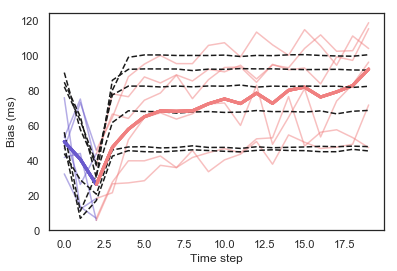

In [150]:
# Load the processed data
plotlst = [0,3,4,5,6,7]
tmax = 20
bias_all_lst = np.zeros((len(plotlst), tmax))
color1 = 'slateblue'
color2 = 'lightcoral'

for id, i in enumerate(plotlst):
    filename = dirlst[i]
    print(filename)
    bias_arr = find_bias_arr(filename, tmax)
    bias = np.sqrt(np.nanmean(bias_arr**2, axis=1)) * 1000
    
    bias_all_lst[id,:] = bias
    plt.plot(bias[:3], color1, alpha=0.5)
    plt.plot(range(2,20), bias[2:], color2, alpha=0.5)
    

# Find individual subject fit
Bias_sim_mean = []

for id in range(len(Isummary)):
    Ival = Isummary[id]
    Kval = Ksummary[id]
    alphaval = alphasummary[id]
    bias_sim_mean, bias_sim_std, _, _ = simulate_sync_cont_bias(ntrials=1000, sigma=0.01, K=Kval, initI=Ival, alpha=alphaval)

    plt.plot(np.nanmean(bias_all_lst,axis=0)[:3], color1, linewidth=3)
    plt.plot(range(2,20), np.nanmean(bias_all_lst,axis=0)[2:], color2, linewidth=3)
    plt.plot(bias_sim_mean, 'k--')
    Bias_sim_mean.append(bias_sim_mean)
plt.xlabel('Time step')
plt.ylabel('Bias (ms)')

In [153]:
Bias_sim_mean = np.array(Bias_sim_mean)
scipy.io.savemat('PlotTools/sync_cont_subject_fit_021619.mat', {'Bias_sim_mean': Bias_sim_mean, 
                                                            'bias_sim_mean': bias_sim_mean,
                                                               'Isummary': Isummary,
                                                               'Ksummary': Ksummary,
                                                               'alphasummary': alphasummary})


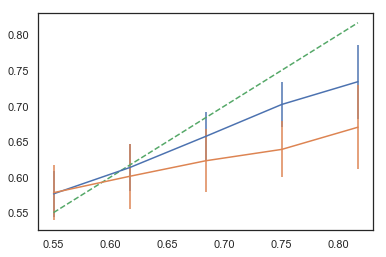

In [158]:
bias_arr = find_bias_arr('C:\\Users\\Sur lab\\Dropbox (MIT)\\Jazayeri\\SyncContData\\AL_2_20170719_SynCon_ITIs.mat', 20)
std_arr = find_std_arr('C:\\Users\\Sur lab\\Dropbox (MIT)\\Jazayeri\\SyncContData\\AL_2_20170719_SynCon_ITIs.mat', 20)

# Plot ts-tp dependence (subject)
bias_first = bias_arr[0,:]
std_first = std_arr[0,:]
bias_third = bias_arr[2,:]
std_third = std_arr[2,:]
bias_fifth = bias_arr[4,:]
std_fifth = std_arr[4,:]

plt.errorbar(durs, durs + bias_third, std_third)
plt.errorbar(durs, durs + bias_fifth, std_fifth)
plt.plot(durs, durs, '--')